In [2]:
import sys
sys.path.append("..")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import data_frame
import tensorflow as tf
import tensorflow_probability as tfp
import tf_keras
import models
from utils import load_config
from sklearn.preprocessing import StandardScaler

In [3]:
dataframes = []
for i in range(1,6):
    df = pd.read_csv(f"../../dataframes/experiment2/ANN_{i}.csv", index_col=0)
    df = df.loc[df["split"]=="test",["Z","Z_pred","faint"]]
    dataframes.append(df)

df = np.array(dataframes).reshape(-1,3)
df_test = df[df[:,2]==False][:,:2]
df_faint = df[df[:,2]==True][:,:2]

In [4]:
n_points = df_test.shape[0]
bins = np.arange(0,5,0.05)
bin_centers = 0.5 * (bins[1:] + bins[:-1])
bin_width = bins[1] - bins[0]

hist_full, _ = np.histogram(df_test[:,1], bins=bins, density=True)

n_bootstrap = 1000
bootstrap_histograms = []

rng = np.random.default_rng(seed=1)
for _ in range(n_bootstrap):
    resampled = rng.choice(df_test[:,1], size=n_points, replace=True)
    hist, _ = np.histogram(resampled, bins=bins, density=True)
    bootstrap_histograms.append(hist)

bootstrap_histograms = np.array(bootstrap_histograms)

hist_mean = np.mean(bootstrap_histograms, axis=0)
hist_lower = np.percentile(bootstrap_histograms, 2.5, axis=0)
hist_upper = np.percentile(bootstrap_histograms, 97.5, axis=0)

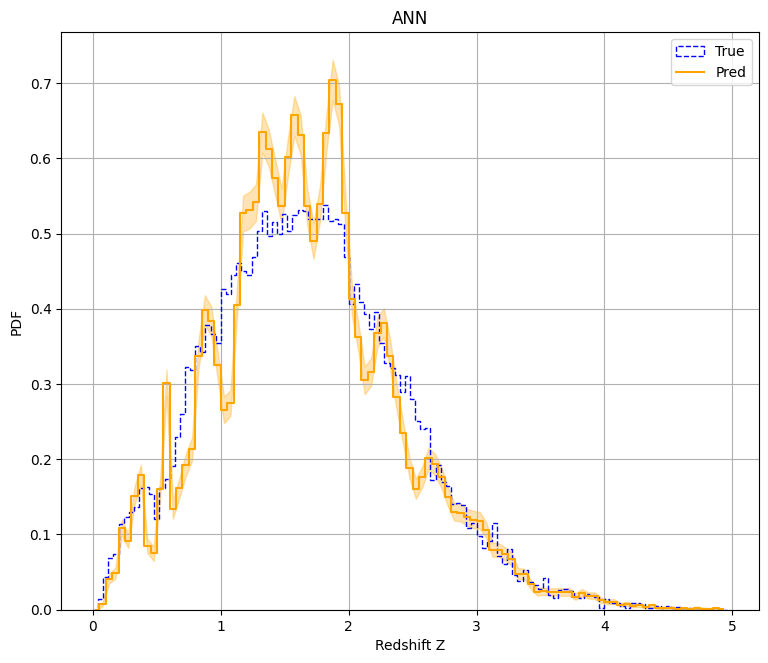

In [5]:
plt.figure(figsize=(9,7.5))
plt.hist(df_test[:,0], bins=np.arange(0,5,0.04), histtype="step", density=True, linestyle="--", color="blue", label="True")
plt.fill_between(bin_centers, hist_lower, hist_upper, color="orange", alpha=0.3)
plt.plot(bin_centers, hist_mean, drawstyle="steps-mid", color="orange", label="Pred")
plt.xlabel("Redshift Z")
plt.ylabel("PDF")
plt.legend()
plt.title("ANN")
plt.grid(True)
plt.show()

In [6]:
filePath = "../../KiDS-DR5-WCScut_x_DESI-DR1-small.fits"

df = data_frame.DataFrame(filePath, "QSO", data_frame.MaxFiller())
X_train, y_train = df.get_train_dataset()
X_test, y_test = df.get_random_test_dataset()
X_faint, y_faint = df.get_faint_test_dataset()

scaler = StandardScaler()
scaler.fit(X_train)

X_test = scaler.transform(X_test)
X_faint = scaler.transform(X_faint)

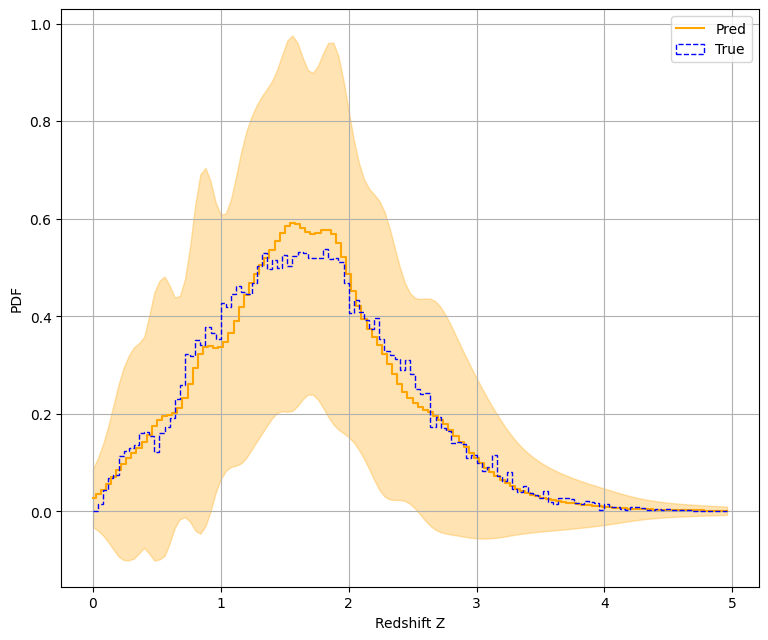

In [124]:
for n in range(1,2):
    config = {"num_components": n}
    
    all_models = []
    for i in range(1, 6):
        model_path = f"../../models/experiment2/MG_{config["num_components"]}_components_{i}/variables/variables"
        model = models.MLModelContext(strategy=models.MixtureGaussian(df, config)).strategy.network
        model.load_weights(model_path).expect_partial()
        all_models.append(model)

    distributions = []
    for model in all_models:
        distributions.append(model(X_test))

    all_log_probs = []
    bins = np.arange(0, 5, 0.04)
    for dist in distributions:
        log_probs = []
        for bin in bins:
            log_probs.append(dist.log_prob(bin).numpy())
        all_log_probs.append(np.array(log_probs).T)
    all_probs = np.concatenate(np.exp(all_log_probs))
    mean_probs = all_probs.mean(axis=0)
    mean_stddevs = all_probs.std(axis=0)

    plt.figure(figsize=(9,7.5))
    plt.plot(bins, mean_probs, color="orange", drawstyle='steps-mid', label="Pred")
    plt.fill_between(bins, mean_probs - mean_stddevs/2, mean_probs + mean_stddevs/2, color="orange", alpha=0.3)
    plt.hist(df_test[:,0], bins=np.arange(0,5,0.04), histtype="step", density=True, color="blue", linestyle="--",label="True")
    plt.xlabel('Redshift Z')
    plt.ylabel('PDF')
    plt.legend()
    plt.grid(True)
    plt.show()

In [132]:
mean_stddevs/2

array([0.05976563, 0.07472029, 0.094306  , 0.11910087, 0.14792007,
       0.17638122, 0.19732201, 0.20985042, 0.2165425 , 0.21555445,
       0.21611865, 0.24404153, 0.27489462, 0.28572568, 0.28649017,
       0.26405412, 0.23640177, 0.2287996 , 0.24457362, 0.28281888,
       0.33432364, 0.3686871 , 0.36735862, 0.33822614, 0.29741794,
       0.27092153, 0.26408315, 0.27483463, 0.29696658, 0.3197431 ,
       0.33471105, 0.34169266, 0.34493932, 0.34606236, 0.345535  ,
       0.3459364 , 0.351863  , 0.36543635, 0.38062122, 0.38490647,
       0.37245616, 0.3505348 , 0.33305416, 0.32987583, 0.3422569 ,
       0.36368498, 0.38342008, 0.39138463, 0.38297725, 0.36130753,
       0.33449596, 0.31054077, 0.29414773, 0.2867523 , 0.28749692,
       0.29282773, 0.29637003, 0.2920541 , 0.27838787, 0.25873563,
       0.2388357 , 0.22369248, 0.21612242, 0.21593088, 0.22104064,
       0.22791263, 0.23302898, 0.23419993, 0.23080163, 0.22366592,
       0.21449365, 0.20431846, 0.19405413, 0.18404403, 0.17424

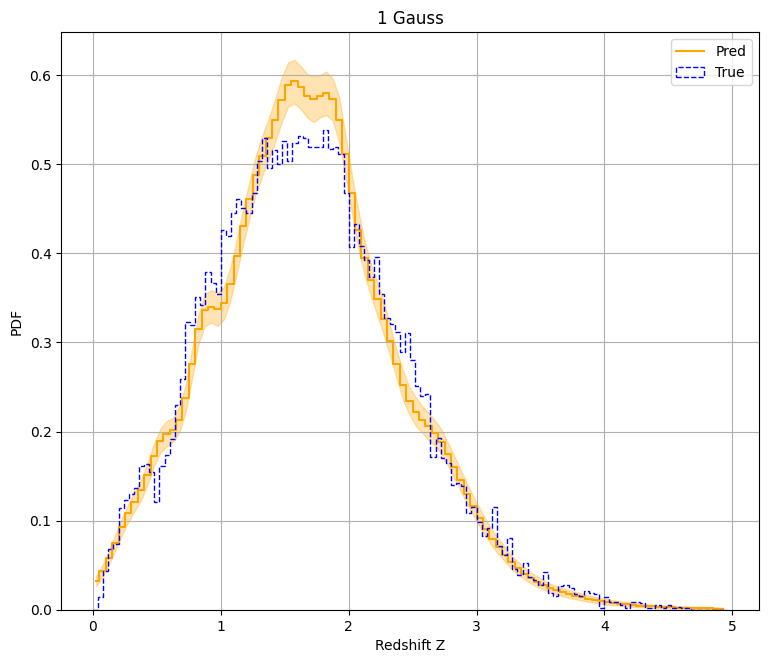

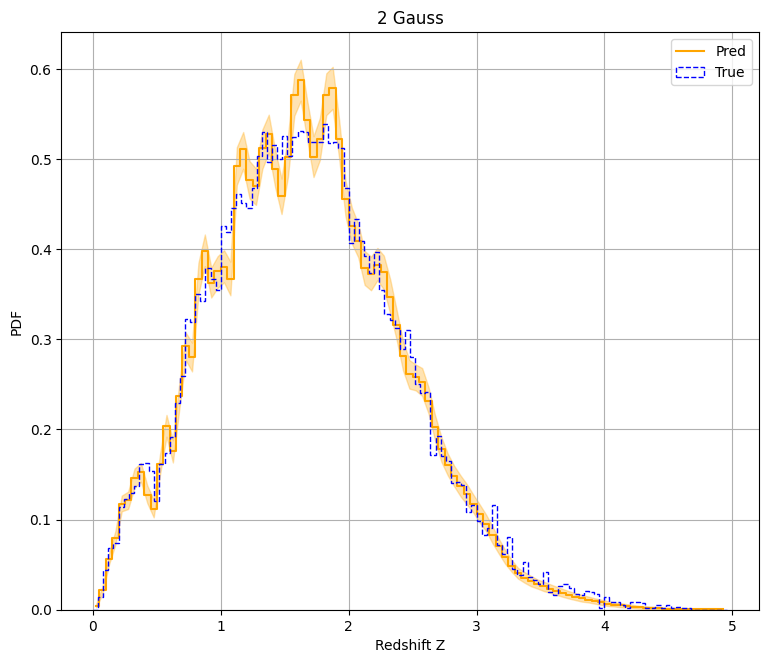

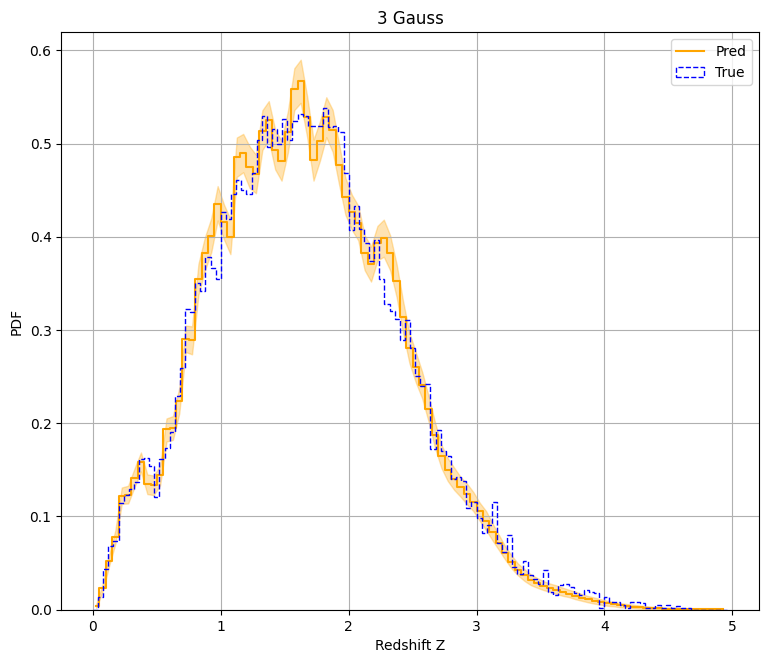

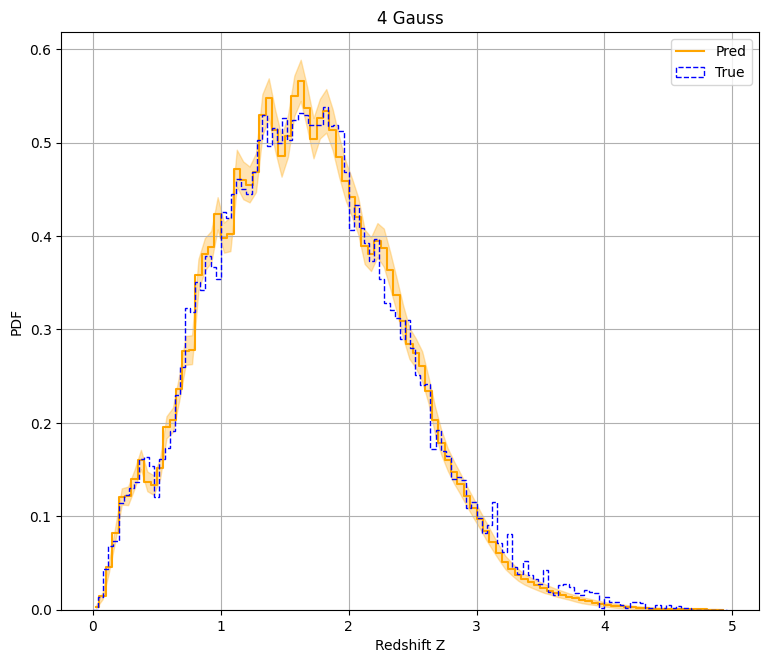

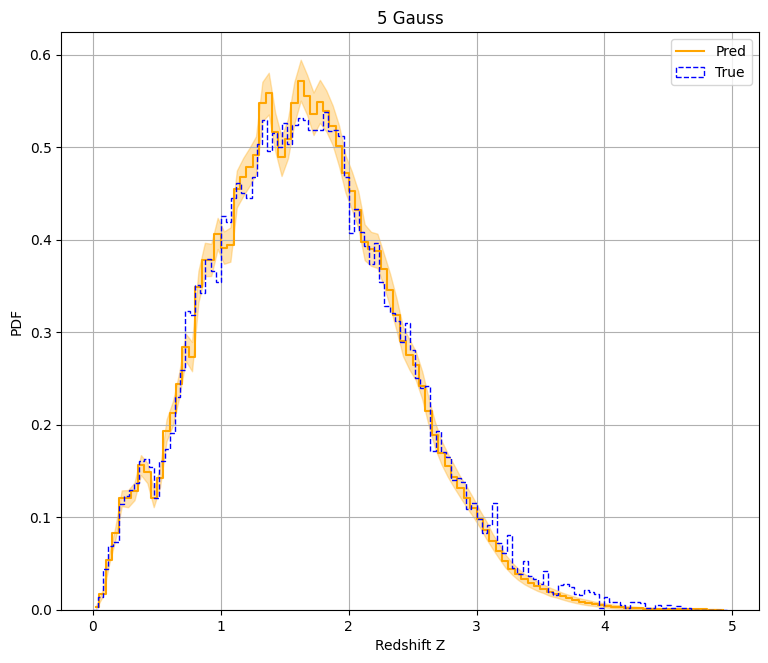

In [9]:
i = 1
for hist_mean, hist_lower, hist_upper in zip(hist_means, hist_lowers, hist_uppers):
    plt.figure(figsize=(9,7.5))
    plt.plot(bin_centers, hist_mean, drawstyle='steps-mid',  color="orange", label=f'Pred')
    plt.fill_between(bin_centers, hist_lower, hist_upper, color="orange", alpha=0.3)
    plt.hist(df_test[:,0], bins=np.arange(0,5,0.04), histtype="step", density=True, color="blue", linestyle="--",label="True")
    plt.xlabel('Redshift Z')
    plt.ylabel('PDF')
    plt.title(f'{i} Gauss')
    plt.legend()
    plt.grid(True)
    plt.show()

    i += 1